In [1]:
import sklearn
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import time

In [2]:
filename = 'train.csv'
df_train = pd.read_csv(filename, index_col='id')
df_train.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
%matplotlib inline

In [4]:
X, y = df_train['text'], df_train['author']

In [5]:
X.shape

(19579,)

In [7]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, y, test_size=0.2, random_state=707)

In [31]:
X_train.shape, X_dev.shape, Y_train.shape, Y_dev.shape

((15663,), (3916,), (15663,), (3916,))

In [5]:
authors = list(df_train['author'].unique())
authors

['EAP', 'HPL', 'MWS']

In [9]:
encoder = preprocessing.LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_dev = encoder.fit_transform(Y_dev)

In [10]:
def plot_confusion_matrix(y_true, y_pred, authors,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [27]:
def train_model(classifier, train_vectors, train_labels, dev_vectors, Y_dev, is_neural_net=False):
    classifier.fit(train_vectors, train_labels)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(dev_vectors)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, Y_dev)

In [34]:
def fit_predict_show_cm(classifier, train_vectors, train_labels, dev_vectors, Y_dev, normalize=True):
    classifier.fit(train_vectors, train_labels)
    predictions = classifier.predict(dev_vectors)
    plot_confusion_matrix(Y_dev, predictions, classes, normalize, cmap=plt.cm.Blues)

In [ ]:
X_

In [13]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_dev_count =  count_vect.transform(X_dev)

In [30]:
X_train_count.shape

(15663, 22920)

In [14]:
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_count, Y_train, X_dev_count, Y_dev)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.8444841675178754


In [15]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_dev_tfidf =  tfidf_vect.transform(X_dev)

In [16]:
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, Y_train, X_dev_tfidf, Y_dev)
print("NB, Word-Level TF-IDF: ", accuracy)

NB, Word-Level TF-IDF:  0.806435137895812


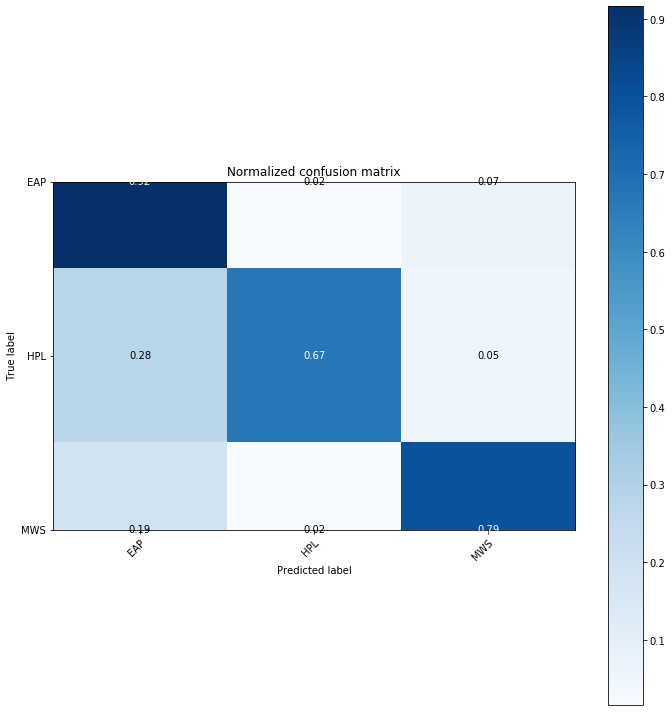

In [35]:
fit_predict_show_cm(naive_bayes.MultinomialNB(), X_train_tfidf, Y_train, X_dev_tfidf, Y_dev)

In [22]:
num_chars = [(i,i) for i in range(11)]
# character level tf-idf
for i, num in enumerate(num_chars):
    print("num_chars = ", i+1)
    start = time.time()
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=num)
    tfidf_vect_ngram_chars.fit(X_train)
    X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
    X_dev_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_dev)
    accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, Y_train, X_dev_tfidf_ngram_chars, Y_dev)
    print("NB, Char-Level TF-IDF with num_chars = ", i+1, ": ", accuracy, "time taken: ", time.time()-start)

num_chars =  1
NB, Char-Level TF-IDF with num_chars =  1 :  0.3924923391215526 time taken:  1.016848087310791
num_chars =  2
NB, Char-Level TF-IDF with num_chars =  2 :  0.3924923391215526 time taken:  0.7792661190032959
num_chars =  3
NB, Char-Level TF-IDF with num_chars =  3 :  0.599591419816139 time taken:  1.8285069465637207
num_chars =  4
NB, Char-Level TF-IDF with num_chars =  4 :  0.7415730337078652 time taken:  2.1172823905944824
num_chars =  5
NB, Char-Level TF-IDF with num_chars =  5 :  0.77170582226762 time taken:  2.3118679523468018
num_chars =  6
NB, Char-Level TF-IDF with num_chars =  6 :  0.7625127681307456 time taken:  2.674678087234497
num_chars =  7
NB, Char-Level TF-IDF with num_chars =  7 :  0.7469356486210419 time taken:  3.3750412464141846
num_chars =  8
NB, Char-Level TF-IDF with num_chars =  8 :  0.7328907048008172 time taken:  4.333759546279907
num_chars =  9
NB, Char-Level TF-IDF with num_chars =  9 :  0.7219101123595506 time taken:  5.2892162799835205
num_cha

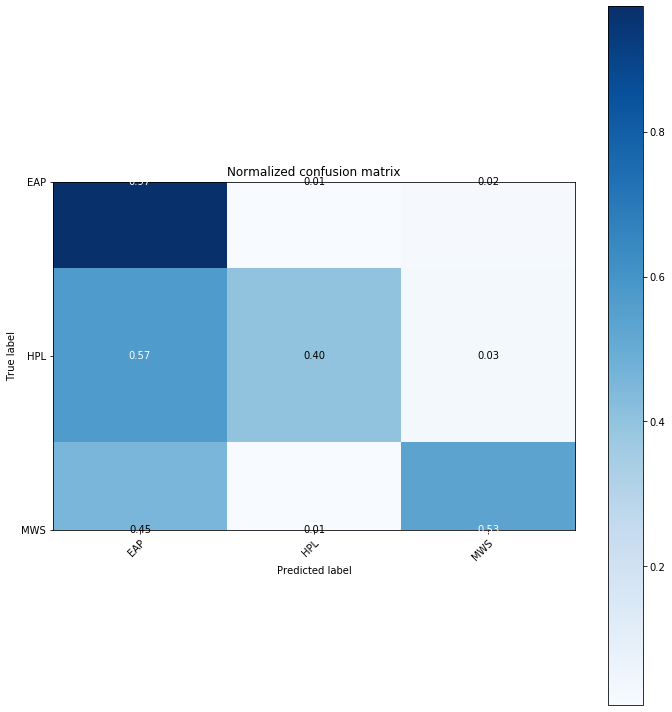

In [23]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train_tfidf_ngram_chars, Y_train)
predictions = classifier.predict(X_dev_tfidf_ngram_chars)
sklearn.metrics.confusion_matrix (Y_dev, predictions, labels=None, sample_weight=None)
plot_confusion_matrix(Y_dev, predictions, classes, normalize=True)

In [11]:
import os
GLOVE_DIR = "/media/D/data/glove/"
GLOVE_FILE = "glove.840B.300d.txt"
GLOVE_PATH = os.path.join(GLOVE_DIR, GLOVE_FILE)
GLOVE_W2V_FILE = "glove.840B.300d.w2vformat.txt"
GLOVE_W2V_PATH = os.path.join(GLOVE_DIR, GLOVE_W2V_FILE)

In [12]:
glove_model = gensim.models.KeyedVectors.load_word2vec_format(GLOVE_W2V_PATH)

In [14]:
wv = glove_model.wv

/home/frass/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [15]:
len(wv['banana'])

300

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, GlobalMaxPooling1D
from keras.optimizers import SGD
import gensim

In [46]:
model = Sequential()
model.add(Conv1D(filters=16,
    kernel_size=3,
    padding='same',
    activation='relu',
    strides=1,
    input_shape=(100, 300)))

In [17]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk import tokenize

In [18]:
def vectorize(dataset):
#     GLOVE_DIR = "/media/D/data/glove/"
#     GLOVE_W2V_FILE = "glove.840B.300d.w2vformat.txt"
#     GLOVE_W2V_PATH = os.path.join(GLOVE_DIR, GLOVE_W2V_FILE)
#     glove_model = gensim.models.KeyedVectors.load_word2vec_format(GLOVE_W2V_PATH)
#     wv = glove_model.wv
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    for sentence in dataset:
        sample_vecs = []
        for token in tokenizer.tokenize(sentence):
            try:
                sample_vecs.append(wv[token])
            except KeyError:
                # print(token, "not in wv")
                pass
        vectorized_data.append(sample_vecs)
    return vectorized_data

In [10]:
df_train['y'] = [lookup[i] for i in df_train.author]

In [11]:
# X, y = df_train['text'], df_train['y']

In [14]:
def preprocess():
    filename = 'train.csv'
    df = pd.read_csv(filename, index_col='id')
    lookup = {a: _ for _, a in enumerate(authors)}
    y_numbers = [lookup[i] for i in df.author]
    y_vecs = []
    for y in y_numbers:
        base_vec = np.zeros(3, dtype='int')
        base_vec[y] = 1
        y_vecs.append(base_vec)
    df['y'] = y_vecs
    return df
df = preprocess()

In [15]:
X, y = df['text'], df['y']

In [27]:
new_y = np.ndarray([len(df['y']), 3])
for _, y in enumerate(df['y']):
    new_y[_] = y[0]


In [28]:
new_y.shape

(19579, 3)

In [22]:
df['y'][0]

array([1, 0, 0])

In [22]:
X = vectorize(X)

In [6]:
lookup = {a: _ for _, a in enumerate(authors)}
y = [lookup[i] for i in y]

In [25]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, y, test_size=0.2, random_state=707)

In [ ]:
type(X_train)

In [ ]:
maxlen = 100
batch_size = 32
embedding_dims = 300
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

In [ ]:
def pad_trunc(data, maxlen):
    new_data = []
    # Create a vector of 0s the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)
    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            # Append the appropriate number 0 vectors to the list
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

In [ ]:
X_train = pad_trunc(X_train, maxlen)
X_dev = pad_trunc(X_dev, maxlen)

In [ ]:
X_train = np.reshape(X_train, (len(X_train), maxlen, embedding_dims))
Y_train = np.array(Y_train)
X_dev = np.reshape(X_dev, (len(X_dev), maxlen, embedding_dims))
Y_dev = np.array(Y_dev)

In [ ]:
print('Build model...')
model = Sequential()
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1, input_shape=(maxlen, embedding_dims)))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
